# Generate multilayer networks

In [106]:
import generate_network, importlib
importlib.reload(generate_network)
from generate_network import *
import os

import numpy as np

N = 5000
L = 5
n0 = 100
n_sets = 5
mu = 0.25
k_min = 5
k_max = 50
t_k = -2.0
theta = 1.0

# p_stay: 0.1 -> 0.8 step 0.1
p_stay_values = [round(x, 1) for x in np.arange(0.1, 0.9, 0.1)]

# churn: 0.1 -> 0.5 step 0.5  (interpreted as [0.1, 0.6) so [0.1, 0.5])
churn_values = [0.1, 0.2, 0.3, 0.4, 0.5]

os.makedirs("sync_data", exist_ok=True)

def fmt_decimal(val: float):
    """
    把0.1 -> '01', 0.5 -> '05', 0.8 -> '08', 0.25 -> '025' (如果以后需要更多位可以扩展)
    这里我们假设只有一位小数，符合当前实验需求
    """
    # val=0.1 -> "0.1" -> split ["0","1"] -> "01"
    s = f"{val:.1f}"  # '0.1'
    whole, frac = s.split(".")  # whole='0', frac='1'
    return f"{whole}{frac.zfill(1)}"  # '01'

for churn in churn_values:
    for p_stay in p_stay_values:
        join_rate = churn
        leaving_rate = churn

        churn_tag = fmt_decimal(churn)     # 0.1 -> '01'
        p_stay_tag = fmt_decimal(p_stay)   # 0.4 -> '04'

        filename = f"churn{churn_tag}-p{p_stay_tag}.csv"
        output_path = os.path.join("sync_data", filename)

        print(f"Generating {output_path} (churn={churn}, p_stay={p_stay})")

        generate_multilayer_network(
            node_pool=N,
            layer=L,
            init_size=n0,
            n_sets=n_sets,
            mu=mu,
            k_min=k_min,
            k_max=k_max,
            t_k=t_k,
            theta=theta,
            p_stay=p_stay,
            join_rate=join_rate,
            leaving_rate=leaving_rate,
            output_path=output_path
        )

Generating sync_data/churn01-p01.csv (churn=0.1, p_stay=0.1)
[{'layer': 0, 'size': 100, 'survivors': 100, 'entrants': 100, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 109, 'survivors': 95, 'entrants': 14, 'jaccard_with_prev': 0.8333333333333334}, {'layer': 2, 'size': 110, 'survivors': 98, 'entrants': 12, 'jaccard_with_prev': 0.8099173553719008}, {'layer': 3, 'size': 110, 'survivors': 99, 'entrants': 11, 'jaccard_with_prev': 0.8181818181818182}, {'layer': 4, 'size': 110, 'survivors': 97, 'entrants': 13, 'jaccard_with_prev': 0.7886178861788617}]
Generating sync_data/churn01-p02.csv (churn=0.1, p_stay=0.2)
[{'layer': 0, 'size': 100, 'survivors': 100, 'entrants': 100, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 109, 'survivors': 95, 'entrants': 14, 'jaccard_with_prev': 0.8333333333333334}, {'layer': 2, 'size': 110, 'survivors': 98, 'entrants': 12, 'jaccard_with_prev': 0.8099173553719008}, {'layer': 3, 'size': 110, 'survivors': 99, 'entrants': 11, 'jaccard_with_prev': 0.818181818181

# Multilayer infomap --JSD

In [ ]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt


# ---------- 文件名解析 ----------
def parse_filename(path: str):
    """
    从文件名 churn01-p04.csv 得到:
        churn = 0.1
        p_stay = 0.4

    规则：
    churn(?P<churntag>\d+)-p(?P<pstaytag>\d+).csv
    取 '01' -> 0.1, '04' -> 0.4
    我们假设都是一位小数（两位字符串，其实是"0"+"4"）
    """
    fname = os.path.basename(path)
    m = re.match(r"churn(\d+)-p(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"无法解析文件名: {fname}")
    churn_tag = m.group(1)   # '01'
    pstay_tag = m.group(2)   # '04'

    def tag_to_float(tag: str) -> float:
        # '01' -> '0.1', '04' -> '0.4', '10' -> '1.0'
        if len(tag) == 1:
            # e.g. '5' -> '0.5'
            s = f"0.{tag}"
        else:
            s = tag[0] + "." + tag[1:]
        return float(s)

    churn_val = tag_to_float(churn_tag)
    p_stay_val = tag_to_float(pstay_tag)

    return churn_val, p_stay_val



relax_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
csv_files = glob.glob("sync_data/churn*-p*.csv")

records = []

for file_path in csv_files:
    churn_val, p_stay_val = parse_filename(file_path)
    print(f"\nProcessing file: {file_path}  (churn={churn_val}, p_stay={p_stay_val})")

    for rate in relax_rates:
        try:
            partition = infomap_communities(file_path, None, jsd_relax_rate=rate)
            mami = compute_layerwise_ami_avg(file_path, partition)

            records.append({
                "churn": churn_val,
                "p_stay": p_stay_val,
                "relax_rate": rate,
                "mami": mami,
                "file": os.path.basename(file_path),
            })

        except Exception as e:
            print(f"✗ Error: {e}")

# ---------- 汇总成 DataFrame ----------
results_df = pd.DataFrame(records)
print("\n=== Summary DataFrame ===")
print(results_df)

# 你可以保存一下，方便之后复现实验
# results_df.to_csv("mami_summary.csv", index=False)

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_41387/2963017230.py:16: SyntaxWarning: invalid escape sequence '\d'
  """



Processing file: sync_data/churn03-p08.csv  (churn=0.3, p_stay=0.8)
  → jsd_relax_rate=0.1
[1.0, 1.0, 1.0, 0.9704557569950958, 0.9153517840774055]
  → jsd_relax_rate=0.2
[1.0, 0.9779801502806446, 1.0, 0.941815987759401, 0.9032664794157479]
  → jsd_relax_rate=0.3
[1.0, 0.9511057459545463, 1.0, 0.9168652738962187, 0.9032664794157479]
  → jsd_relax_rate=0.4
[1.0, 0.9655154315380974, 0.9618367432837739, 0.9168652738962187, 0.9032664794157479]
  → jsd_relax_rate=0.5
[1.0, 0.9265593271053483, 0.9459621932331068, 0.9044677517976695, 0.9032664794157479]
  → jsd_relax_rate=0.6
[1.0, 0.9214696650364502, 0.8516459668253483, 0.867184815066855, 0.8389116741780673]

Processing file: sync_data/churn02-p08.csv  (churn=0.2, p_stay=0.8)
  → jsd_relax_rate=0.1
[1.0, 0.9528169917773505, 1.0, 1.0, 0.95337022123627]
  → jsd_relax_rate=0.2
[1.0, 0.9464864132277805, 1.0, 1.0, 0.9232202421422041]
  → jsd_relax_rate=0.3
[1.0, 0.9413689116830782, 0.9339752929189471, 1.0, 0.8708278630412374]
  → jsd_relax_rate=0

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_41387/298748130.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 给 colorbar 留空间


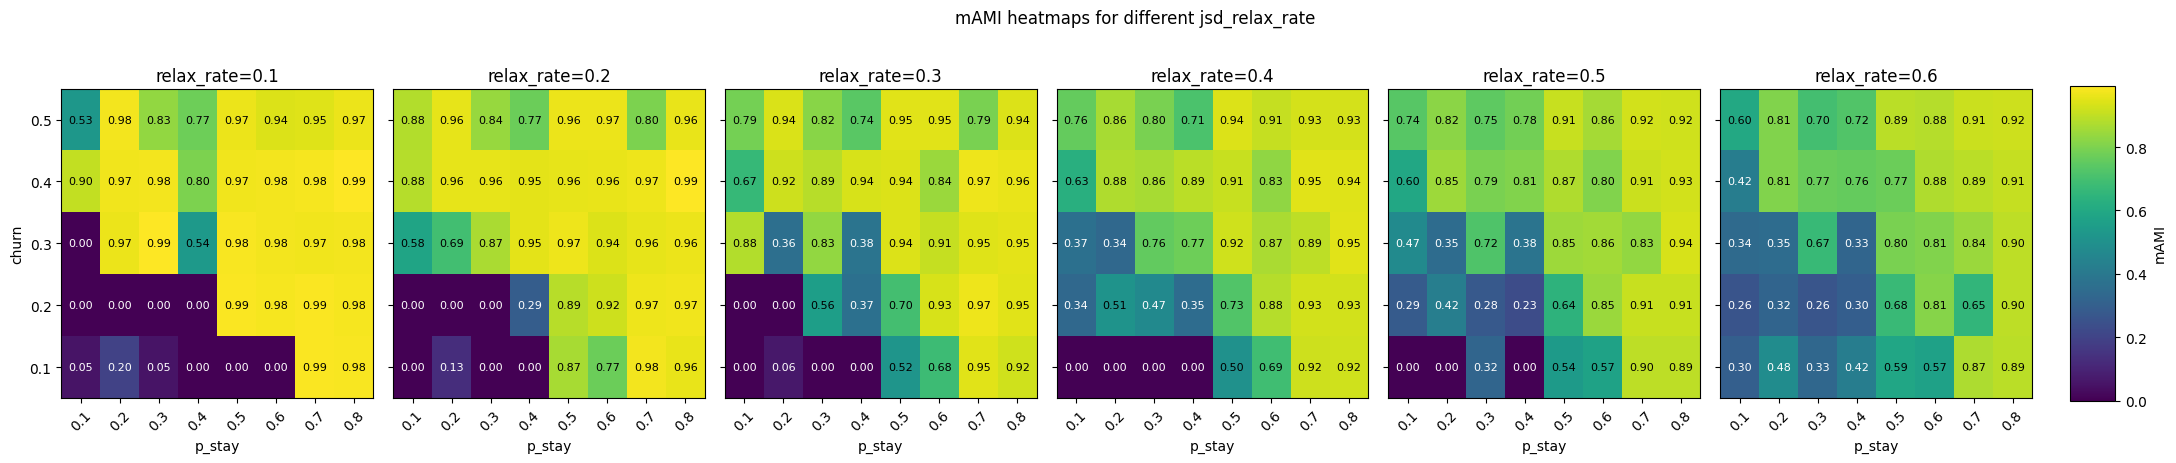

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

heat_df = (
    results_df
    .groupby(["relax_rate", "churn", "p_stay"], as_index=False)["mami"]
    .mean()
)

relax_rates_unique = sorted(heat_df["relax_rate"].unique())
churn_unique = sorted(heat_df["churn"].unique())
p_stay_unique = sorted(heat_df["p_stay"].unique())

n_rates = len(relax_rates_unique)

fig, axes = plt.subplots(
    1, n_rates,
    figsize=(3.8 * n_rates, 4.5),
    sharex=True, sharey=True
)

if n_rates == 1:
    axes = [axes]

vmin = heat_df["mami"].min()
vmax = heat_df["mami"].max()

for ax, rrate in zip(axes, relax_rates_unique):
    sub = heat_df[heat_df["relax_rate"] == rrate]
    pivot_mat = sub.pivot(index="churn", columns="p_stay", values="mami")
    pivot_mat = pivot_mat.reindex(index=churn_unique, columns=p_stay_unique)

    im = ax.imshow(
        pivot_mat.values,
        aspect="auto",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap="viridis"
    )

    ax.set_xticks(range(len(p_stay_unique)))
    ax.set_xticklabels([str(v) for v in p_stay_unique], rotation=45)
    ax.set_yticks(range(len(churn_unique)))
    ax.set_yticklabels([str(v) for v in churn_unique])

    ax.set_title(f"relax_rate={rrate}")
    ax.set_xlabel("p_stay")
    if ax == axes[0]:
        ax.set_ylabel("churn")

    # === 数值标注 ===
    for i_churn, churn_val in enumerate(churn_unique):
        for j_p, pstay_val in enumerate(p_stay_unique):
            val = pivot_mat.loc[churn_val, pstay_val]
            if pd.notna(val):
                # 颜色深时文字改浅，颜色浅时文字改深
                text_color = "white" if val < (vmin + vmax) / 2 else "black"
                ax.text(
                    j_p,
                    i_churn,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color=text_color
                )


fig.subplots_adjust(right=0.88, wspace=0.2)
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("mAMI")

plt.suptitle("mAMI heatmaps for different jsd_relax_rate", y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.show()

In [62]:
from measurement import *

compute_layerwise_ami_avg("test","sync_data","output")

[0.9861957477848039, 0.9385468600178081, 0.890434526956545, 0.8384419444494823, 0.8147715433347329]


0.8936781245086743

# GenLouvain
Original GenLouvain with pre-scripted homogenous inter-layer coupling strength

In [88]:
import algorithms
from importlib import reload
reload(algorithms)
from algorithms import *

genlouvain_communities(
    input_csv="sync_data/test.csv",
    output_csv="test_communities.csv",
    genlouvain_path="GenLouvain",
    omega=0.1,
    gamma=1.0,
    directed=False,
    random_state=None,
    use_iterated=True,
)

## IterModMax
Find a suitable inter-layer coupling strength by the equivalence between SBM and modualarity maximisation. However, the coupling stength between state-node pairs are still homogenous. 

## GW coupling

In [ ]:
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import networkx as nx

# ========= CONFIG =========
CSV_PATH = "sync_data/test.csv"
# node2vec
DIMENSIONS = 32
WALK_LENGTH = 80
NUM_WALKS = 10
P = 1.0
Q = 1.0
WINDOW = 10
WORKERS = 4
SEED = 42
# GW & interlayer linking
GW_EMB_METRIC = "euclidean"       # 'euclidean' or 'cosine'
TOP_K = 5                         # 每个源节点跨层只保留前 K 个目标
MIN_WEIGHT = 1e-3                 # 小于阈值的跨层边丢弃
ALPHA = 2.0                       # 层间全局缩放 Omega = exp(-ALPHA * GW)
INTRA_EDGE_WEIGHT = 1.0           # 层内边权（CSV 若无权重，就用常数 1）

# ========= deps =========
from node2vec import Node2Vec
from ot.gromov import gromov_wasserstein, gromov_wasserstein2
from infomap import Infomap


# ---------- data / graphs ----------
def read_edges(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    req = {"u", "v", "layer"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"CSV missing required columns: {sorted(miss)}")
    # 统一为字符串 id
    df["u"] = df["u"].astype(str)
    df["v"] = df["v"].astype(str)
    df["layer"] = df["layer"].astype(str)
    return df

def build_layer_graphs(df: pd.DataFrame) -> Dict[str, nx.Graph]:
    graphs: Dict[str, nx.Graph] = {}
    for layer, gdf in df.groupby("layer"):
        G = nx.Graph()
        if "w" in gdf.columns:
            edges = [(u, v, float(w)) for u, v, w in gdf[["u", "v", "w"]].itertuples(index=False)]
            G.add_weighted_edges_from(edges)
        else:
            G.add_edges_from(gdf[["u", "v"]].itertuples(index=False, name=None))
            # 给无权图统一权重 1
            nx.set_edge_attributes(G, INTRA_EDGE_WEIGHT, "weight")
        # 确保孤立点也在图里（如果 CSV 有只出现一次的端点）
        for col in ["u", "v"]:
            for n in gdf[col].unique():
                if n not in G:
                    G.add_node(n)
        graphs[layer] = G
    return graphs


# ---------- embeddings ----------
def compute_node2vec_embeddings(
    G: nx.Graph,
    dimensions=64, walk_length=80, num_walks=10, p=1.0, q=1.0,
    window=10, workers=1, seed=42
) -> pd.DataFrame:
    if len(G) == 0:
        raise ValueError("Empty graph.")
    def _fit(n_jobs):
        n2v = Node2Vec(G, dimensions=dimensions, walk_length=walk_length,
                       num_walks=num_walks, p=p, q=q, workers=n_jobs,
                       seed=seed, quiet=True)
        return n2v.fit(window=window, min_count=1, batch_words=4)
    try:
        model = _fit(workers)
    except Exception as e:
        print(f"[WARN] node2vec workers={workers} failed: {e}. Fallback to workers=1.")
        model = _fit(1)
    nodes = [str(n) for n in G.nodes()]
    X = np.vstack([model.wv[n] for n in nodes])
    emb = pd.DataFrame(X, index=nodes, columns=[f"f{i}" for i in range(X.shape[1])])
    emb.index.name = "node"
    return emb

def pairwise_from_embeddings(emb: pd.DataFrame, metric="euclidean") -> np.ndarray:
    X = emb.values.astype(float)
    if metric == "euclidean":
        s = np.sum(X * X, axis=1, keepdims=True)
        D2 = s + s.T - 2 * (X @ X.T)
        np.maximum(D2, 0.0, out=D2)
        return np.sqrt(D2, dtype=float)
    elif metric == "cosine":
        n = np.linalg.norm(X, axis=1, keepdims=True)
        n[n == 0] = 1.0
        Xn = X / n
        S = np.clip(Xn @ Xn.T, -1.0, 1.0)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'.")

def gw_coupling_and_distance(emb1: pd.DataFrame, emb2: pd.DataFrame, metric="euclidean"):
    emb1 = emb1.sort_index()
    emb2 = emb2.sort_index()
    nodes1 = emb1.index.to_list()
    nodes2 = emb2.index.to_list()
    C1 = pairwise_from_embeddings(emb1, metric=metric)
    C2 = pairwise_from_embeddings(emb2, metric=metric)
    n1, n2 = C1.shape[0], C2.shape[0]
    p = np.ones(n1) / max(n1, 1)
    q = np.ones(n2) / max(n2, 1)
    # π（最优耦合，带熵正则版可用 ot.gromov.entropic_gromov_wasserstein）
    pi = gromov_wasserstein(C1, C2, p, q, loss_fun="square_loss")
    # GW^2
    gw2 = gromov_wasserstein2(C1, C2, p, q, loss_function="square_loss")
    gw = float(np.sqrt(max(gw2, 0.0)))
    return pi, nodes1, nodes2, gw

def state_id(node: str, layer: str) -> str:
    # 选择一个不太可能出现在节点/层名里的分隔符
    return f"{node}|{layer}"


def build_infomap_with_gw(
    graphs: Dict[str, nx.Graph],
    embeddings: Dict[str, pd.DataFrame],
    layer_order: List[str],
    top_k: int = 5,
    min_weight: float = 1e-3,
    alpha: float = 2.0,
    emb_metric: str = "euclidean",
    intra_weight_from_attr: str = "weight"
) -> Tuple[Infomap, Dict[int, Tuple[str, str]]]:
    """
    构造扁平化“状态节点图”，节点是 (node, layer) 的组合映射为 int。
    返回 (Infomap实例, id2state)，其中 id2state[i] = (node, layer)
    """

    # ----------- 1️⃣ 建立全局状态节点映射 -----------
    state2id = {}
    id2state = {}
    next_id = 1

    # 遍历所有层的所有节点，创建唯一的整数ID
    for layer in layer_order:
        for n in graphs[layer].nodes():
            key = (str(n), str(layer))
            state2id[key] = next_id
            id2state[next_id] = key
            next_id += 1

    im = Infomap("--two-level --silent")

    # ----------- 2️⃣ 层内边 -----------
    for layer in layer_order:
        G = graphs[layer]
        for u, v, d in G.edges(data=True):
            w = float(d.get(intra_weight_from_attr, INTRA_EDGE_WEIGHT))
            uid = state2id[(str(u), str(layer))]
            vid = state2id[(str(v), str(layer))]
            im.addLink(int(uid), int(vid), float(w))

        # 如果整层没有边，加极小自环，保证节点可见
        if G.number_of_edges() == 0:
            for n in G.nodes():
                nid = state2id[(str(n), str(layer))]
                im.addLink(int(nid), int(nid), 1e-12)

    # ----------- 3️⃣ 层间边 (GW 耦合) -----------
    for t in range(len(layer_order) - 1):
        la, lb = layer_order[t], layer_order[t + 1]
        emb_a, emb_b = embeddings[la].sort_index(), embeddings[lb].sort_index()
        pi, nodes_a, nodes_b, gw = gw_coupling_and_distance(emb_a, emb_b, metric=emb_metric)

        Omega = float(np.exp(-alpha * gw))  # 全局缩放
        row_sums = pi.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        P = pi / row_sums

        na, nb = P.shape
        for ia in range(na):
            k_use = min(top_k, nb) if top_k > 0 else nb
            idx = np.argpartition(-P[ia, :], kth=k_use - 1)[:k_use]
            idx = idx[np.argsort(-P[ia, idx])]

            src_name = nodes_a[ia]
            src_id = state2id[(str(src_name), str(la))]

            for jb in idx:
                w = float(P[ia, jb]) * Omega
                if w < min_weight:
                    continue
                dst_name = nodes_b[jb]
                dst_id = state2id[(str(dst_name), str(lb))]
                im.addLink(int(src_id), int(dst_id), float(w))

    return im, id2state


# ============ RUN ============
df = read_edges(CSV_PATH)
graphs = build_layer_graphs(df)
layer_names = sorted(graphs.keys(), key=lambda x: x)  # 你也可以自定义顺序

# 逐层嵌入
embeddings: Dict[str, pd.DataFrame] = {}
for layer in layer_names:
    embeddings[layer] = compute_node2vec_embeddings(
        graphs[layer],
        dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS,
        p=P, q=Q, window=WINDOW, workers=WORKERS, seed=SEED
    )

    
im, id2state = build_infomap_with_gw(
    graphs, embeddings, layer_order=layer_names,
    top_k=TOP_K, min_weight=MIN_WEIGHT, alpha=ALPHA, emb_metric=GW_EMB_METRIC
)

im.run()

# 提取社区划分结果
partition = {n.node_id: n.module_id for n in im.tree if n.is_leaf}

# 映射回 (node, layer)
rows = []
for nid, com in partition.items():
    if nid in id2state:
        node, layer = id2state[nid]
        rows.append((node, layer, com))

assignments_df = pd.DataFrame(rows, columns=["node_id", "layer", "community"])
assignments_df.to_csv("out/infomap_state_nodes.csv", index=False)
print(f"Saved community assignments -> out/infomap_state_nodes.csv ({len(rows)} nodes)")


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Saved community assignments -> out/infomap_state_nodes.csv (1820 nodes)


In [21]:
from measurement import *

compute_layerwise_ami_avg("test","sync_data",output_dir="output")

[0.6052790034077675, 0.9344613973053375, 0.8789571703502499, 0.9038561123671298, 0.9164749858448414]


0.8478057338550652

In [44]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from typing import Dict, Tuple, List
from hetero_coupling import *

def layer_adjacency_matrix(G: nx.Graph, node_order: List[str]) -> np.ndarray:
    """
    把单层加权无向图转成邻接矩阵 (|V|x|V|), 顺序由 node_order 决定.
    """
    idx = {n: i for i, n in enumerate(node_order)}
    N = len(node_order)
    rows = []
    cols = []
    vals = []
    for u, v, data in G.edges(data=True):
        if u not in idx or v not in idx:
            continue
        w = data.get("weight", 1.0)
        i = idx[u]
        j = idx[v]
        rows.append(i); cols.append(j); vals.append(w)
        rows.append(j); cols.append(i); vals.append(w)
    if N == 0:
        return np.zeros((0, 0), dtype=float)
    A = sparse.coo_matrix((vals, (rows, cols)), shape=(N, N)).toarray()
    np.fill_diagonal(A, 0.0)
    return A

def supra_adjacency_from_pi(
    graphs: Dict[str, nx.Graph],
    embeddings: Dict[str, pd.DataFrame],
    metric: str = "euclidean",
    omega_scale: float = 1.0,
) -> Tuple[np.ndarray, List[Tuple[str, str]], Dict[str, List[str]]]:
    """
    构建超邻接矩阵 A_supra (dense)，以及映射关系。

    重要区别（和上一版比）：
    - 只在“相邻层”之间加入跨层耦合 (layer_t <-> layer_{t+1})
      不再对所有成对层 (t, s) 都加边。

    返回:
      A_supra: (sum_l |V_l|) x (sum_l |V_l|) 的 numpy.ndarray
      global_index: [(layer, node), ...] 对应 A_supra 的行/列顺序
      layer_nodes: {layer: [node,...]} 每层节点顺序
    """
    # 让层有一个稳定顺序（时间顺序 / 层序）
    layers_sorted = sorted(graphs.keys())

    # 1. 为每一层确定节点顺序（优先用该层 embedding 的 index）
    layer_nodes: Dict[str, List[str]] = {}
    for layer in layers_sorted:
        nodes_emb = [str(n) for n in embeddings[layer].index.tolist()]
        extra = [str(n) for n in graphs[layer].nodes() if str(n) not in nodes_emb]
        full_nodes = nodes_emb + extra
        # 去重保持顺序
        seen = set()
        ordered_nodes = []
        for n in full_nodes:
            if n not in seen:
                seen.add(n)
                ordered_nodes.append(n)
        layer_nodes[layer] = ordered_nodes

    # 2. 每层内邻接块
    layer_adj_blocks: Dict[str, np.ndarray] = {}
    for layer in layers_sorted:
        layer_adj_blocks[layer] = layer_adjacency_matrix(
            graphs[layer],
            layer_nodes[layer]
        )

    # 3. 只计算“相邻层(t, t+1)”的跨层块
    #    coupling_blocks[(la, lb)] = 矩阵 (|V_la| x |V_lb|)
    coupling_blocks: Dict[Tuple[str, str], np.ndarray] = {}

    for k in range(len(layers_sorted) - 1):
        la = layers_sorted[k]
        lb = layers_sorted[k + 1]

        emb_a = embeddings[la]
        emb_b = embeddings[lb]

        # pi: shape (|V_la'| x |V_lb'|)
        # nodes_a, nodes_b 对应 pi 的行/列索引
        pi, nodes_a, nodes_b, gw_dist = gw_coupling_and_distance(
            emb_a, emb_b, metric=metric
        )

        # 我们需要把 pi 的行/列顺序对齐到 layer_nodes[la], layer_nodes[lb]
        idx_a = {n: i for i, n in enumerate(nodes_a)}
        idx_b = {n: j for j, n in enumerate(nodes_b)}

        na = len(layer_nodes[la])
        nb = len(layer_nodes[lb])

        C = np.zeros((na, nb), dtype=float)

        # 把 GW 耦合强度映射到 (la节点顺序, lb节点顺序)
        for ia, node_a in enumerate(layer_nodes[la]):
            ka = idx_a.get(node_a, None)
            if ka is None:
                continue
            row_pi = pi[ka, :]  # pi[ka, :] 对应 node_a -> 所有 node_b
            for ib, node_b in enumerate(layer_nodes[lb]):
                kb = idx_b.get(node_b, None)
                if kb is None:
                    continue
                C[ia, ib] = row_pi[kb]

        if omega_scale != 1.0:
            C = C * float(omega_scale)

        # 保存 t -> t+1 的块 和 对称的 t+1 -> t
        coupling_blocks[(la, lb)] = C
        coupling_blocks[(lb, la)] = C.T

    # 4. 把这些块拼成一个大矩阵
    # 4a. 给每层一个 offset，方便把子块放进总矩阵
    layer_offset: Dict[str, int] = {}
    offset = 0
    for layer in layers_sorted:
        layer_offset[layer] = offset
        offset += len(layer_nodes[layer])
    total_N = offset

    A_supra = np.zeros((total_N, total_N), dtype=float)

    # 4b. 放每层内部邻接 (对角块)
    for layer in layers_sorted:
        A_block = layer_adj_blocks[layer]
        base = layer_offset[layer]
        na = A_block.shape[0]
        if na == 0:
            continue
        A_supra[base:base+na, base:base+na] = A_block

    # 4c. 放相邻层之间的耦合块
    for (la, lb), C_ab in coupling_blocks.items():
        base_a = layer_offset[la]
        base_b = layer_offset[lb]
        na, nb = C_ab.shape
        if na == 0 or nb == 0:
            continue
        A_supra[base_a:base_a+na, base_b:base_b+nb] = C_ab

    # 5. global_index: A_supra 的行/列对应哪个 (layer,node)
    global_index: List[Tuple[str, str]] = []
    for layer in layers_sorted:
        for node in layer_nodes[layer]:
            global_index.append((layer, node))

    return A_supra, global_index, layer_nodes, layer_adj_blocks, coupling_blocks

def modularity_matrix(A: np.ndarray) -> np.ndarray:
    """
    给定加权无向图的邻接矩阵 A，构造经典 Newman-Girvan 模块度矩阵 B:
        B = A - (k k^T) / (2m)
    其中 k 是度向量, 2m = sum(A_ij).
    """
    # 度
    k = A.sum(axis=1, keepdims=True)  # shape (N,1)
    two_m = float(k.sum())            # scalar = sum of all weights
    if two_m <= 0:
        # 没边的情况下，B 就是 0 矩阵
        return np.zeros_like(A, dtype=float)

    expected = (k @ k.T) / two_m      # outer product / (2m)
    B = A - expected
    # 可选：去掉非常小的数值噪声
    B[np.abs(B) < 1e-15] = 0.0
    return B


def build_B_from_blocks(
    layer_adj_blocks: Dict[str, np.ndarray],
    coupling_blocks: Dict[Tuple[str, str], np.ndarray],
    layer_nodes: Dict[str, List[str]],
    gamma: float = 1.0,
) -> np.ndarray:
    """
    构造与 multiord 等价的模块度矩阵 B（block-wise）。

    参数:
    - layer_adj_blocks: {layer: A_s (n_s x n_s)} 只包含层内邻接，不包含跨层耦合
    - coupling_blocks: {(la,lb): C_{ab} (n_a x n_b)} 仅包含要作为跨层耦合直接加入 B 的块。
                       对 (la,lb) 和 (lb,la) 应该互为转置或同时提供。
                       只需提供相邻层的块（或所有你希望有耦合的块）。
    - layer_nodes: {layer: [node,...]} 决定 block 的顺序与 offset
    - gamma: 分辨率参数（对所有层同一个 gamma；也可改成 dict per-layer）

    返回:
    - B: numpy.ndarray, shape (N_total, N_total)
    """
    # 1) 层顺序与 offset
    layers = sorted(layer_nodes.keys())
    layer_offset = {}
    offset = 0
    for layer in layers:
        layer_offset[layer] = offset
        offset += len(layer_nodes[layer])
    N = offset

    # 2) 初始化 B 为 0
    B = np.zeros((N, N), dtype=float)

    # 3) 对角块：每层独立计算 expected_s = (k_s k_s^T) / (2 m_s)
    for layer in layers:
        A = layer_adj_blocks.get(layer)
        if A is None:
            # 空层（无节点）
            continue
        base = layer_offset[layer]
        n = A.shape[0]
        # 层内度与2m_s
        k_s = A.sum(axis=1, keepdims=True)        # (n,1)
        two_m_s = float(k_s.sum())                # scalar
        if two_m_s > 0:
            expected_s = (k_s @ k_s.T) / two_m_s
        else:
            expected_s = np.zeros_like(A)
        B_block = A - gamma * expected_s
        # 写进 B 的对角块
        B[base:base+n, base:base+n] = B_block

    # 4) 添加跨层耦合块（直接加入 B 的 off-diagonal）
    #    coupling_blocks[(la,lb)] 形状应为 (len(layer_nodes[la]), len(layer_nodes[lb]))
    for (la, lb), C in coupling_blocks.items():
        if la not in layer_offset or lb not in layer_offset:
            # 忽略未知层（安全检查）
            continue
        base_a = layer_offset[la]
        base_b = layer_offset[lb]
        na = C.shape[0]
        nb = C.shape[1]
        # 在 B 的对应位置直接加上 C（可能是稀疏的）
        # 如果 (lb,la) 也在 coupling_blocks，会在其迭代时加对称项两次——
        # 因此，期望 coupling_blocks[(lb,la)] == C.T，或只在上三角加入并手动对称填充。
        B[base_a:base_a+na, base_b:base_b+nb] += C
    # 5) 对称化（保证数值对称）
    B = (B + B.T) / 2.0
    # 清理数值噪声
    B[np.abs(B) < 1e-15] = 0.0
    return B

def run_genlouvain_on_B(
    B: np.ndarray,
    matlab_path_to_genlouvain: str,
    random_state: int | None = None,
    use_iterated: bool = True,
):
    """
    把我们在 Python 里构造的 B 发到 MATLAB，调用 genlouvain / iterated_genlouvain，
    返回 S (社区标签向量) 和 Q_raw / Q (模块度)。
    """
    import matlab.engine
    import matlab

    eng = matlab.engine.start_matlab()
    # 确保 GenLouvain 在 MATLAB 的 path 里
    _ = eng.addpath(eng.genpath(matlab_path_to_genlouvain), nargout=1)

    # 转成 matlab.double
    # 注意：genlouvain 期望的是稀疏 B，一般很大时要稀疏；这里先给 dense 版。
    B_matlab = matlab.double(B.tolist())

    if random_state is not None:
        eng.eval(f"rng({int(random_state)});", nargout=0)

    # 试 iterated_genlouvain，回退 genlouvain
    try:
        if use_iterated:
            S, Q_raw = eng.iterated_genlouvain(B_matlab, [], [], 0, nargout=2)
        else:
            S, Q_raw = eng.genlouvain(B_matlab, nargout=2)
    except Exception:
        S, Q_raw = eng.genlouvain(B_matlab, nargout=2)

    # 取回来 S (长度 = B.shape[0])，Q_raw 是未除以 2m 的版本（在标准流程里 Q = Q_raw / (2m)）
    S_py = np.array(S).reshape(-1)
    # 为了得到标准化模块度 Q，我们自己也可以算:
    # two_m for supra graph = sum(A) (我们可以从外面传进来，如果想严格)
    return S_py, float(Q_raw)


def multilayer_partition(
    csv_path: str,
    omega_scale: float,
    matlab_path_to_genlouvain: str,
    metric: str = "euclidean",
    node2vec_dim: int = 64,
    seed: int = 42,
):
    """
    端到端:
    1. 读边并按 layer 分图
    2. 每层跑 node2vec
    3. 用 GW 耦合构造跨层耦合 + 超邻接矩阵 A_supra
    4. 构造模块度矩阵 B
    5. 调用 MATLAB genlouvain
    6. 输出 (layer, node, community) 的 DataFrame
    """

    # 1. 读 CSV & 按层建图
    df = read_edges(csv_path)
    graphs = build_layer_graphs(df)

    # 2. 每层 embedding
    embeddings = {}
    for layer, G in graphs.items():
        emb = compute_node2vec_embeddings(
            G,
            dimensions=node2vec_dim,
            walk_length=80,
            num_walks=10,
            p=1.0,
            q=1.0,
            window=10,
            workers=4,
            seed=seed,
        )
        embeddings[layer] = emb

    # 3. 超邻接矩阵
    A_supra, global_index, layer_nodes, layer_adj_blocks, coupling_blocks = supra_adjacency_from_pi(
        graphs,
        embeddings,
        metric=metric,
        omega_scale=omega_scale,
    )

    # 4. 模块度矩阵 B
    B = build_B_from_blocks(layer_adj_blocks, coupling_blocks, layer_nodes, gamma=1.0)

    # 5. 调 MATLAB: genlouvain
    S_vec, Q_raw = run_genlouvain_on_B(
        B,
        matlab_path_to_genlouvain=matlab_path_to_genlouvain,
        random_state=seed,
        use_iterated=True,
    )

    # 6. 还原回 (node, layer)
    # global_index[i] = (layer, node) 对应 B[i,i]
    rows = []
    for idx_global, (layer, node) in enumerate(global_index):
        rows.append({
            "layer": layer,
            "node_id": node,
            "community": int(S_vec[idx_global]),
        })

    output_csv = "output/test_communities.csv"
    part_df = pd.DataFrame(rows, columns=["node_id", "layer", "community"])
    part_df.to_csv(output_csv, index=False)
    return part_df, Q_raw, A_supra, B

result_df, _, A_supra, B = multilayer_partition(
    csv_path="sync_data/test.csv",
    omega_scale=5000.0,   # 可以加大，比如5.0让跨层更粘
    matlab_path_to_genlouvain="GenLouvain",  # 本地GenLouvain的路径
    metric="cosine",
    node2vec_dim=32,
    seed=42,
)

print(result_df.head())

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

  node_id layer  community
0       1     0          1
1    7363     0          2
2    9055     0          1
3    4406     0          1
4    4846     0          1


In [47]:
from measurement import *

compute_layerwise_ami_avg("test","sync_data",output_dir="output")

[0.9445672564198302, 0.9351549311866627, 0.9230846559640049, 0.9185379001205537, 0.9174622576655929]


0.9277614002713289

In [46]:
import algorithms, importlib
importlib.reload(algorithms)
from algorithms import *

genlouvain_communities("sync_data/test.csv","output/test_communities.csv",algorithm="itermodmax")

Initialisation: gamma = 1.00, omega = 1.00
Iteration 1: gamma = 1.00, omega = 1.00, p = 0.80, K = 47
Iteration 2: gamma = 0.80, omega = 1.00, p = 0.80, K = 44
Iteration 3: gamma = 0.64, omega = 1.00, p = 0.80, K = 44
Iteration 4: gamma = 0.51, omega = 1.00, p = 0.80, K = 44
Iteration 5: gamma = 0.41, omega = 1.00, p = 0.80, K = 39
Iteration 6: gamma = 0.33, omega = 1.00, p = 0.80, K = 32
Iteration 7: gamma = 0.26, omega = 1.00, p = 0.80, K = 20
Iteration 8: gamma = 3.33, omega = 0.52, p = 0.80, K = 50
Iteration 9: gamma = 2.66, omega = 0.52, p = 0.80, K = 50
Iteration 10: gamma = 2.13, omega = 0.52, p = 0.80, K = 50
Iteration 11: gamma = 1.70, omega = 0.52, p = 0.80, K = 50
Iteration 12: gamma = 1.36, omega = 0.52, p = 0.80, K = 49
Iteration 13: gamma = 1.09, omega = 0.52, p = 0.80, K = 49
Iteration 14: gamma = 0.87, omega = 0.52, p = 0.79, K = 48
Iteration 15: gamma = 0.70, omega = 0.52, p = 0.80, K = 48
Iteration 16: gamma = 0.56, omega = 0.52, p = 0.80, K = 44
Iteration 17: gamma = 